## Importing Necessary Libraries


In [1]:
import time
import math
import random

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import dataset
import cv2

from sklearn.metrics import confusion_matrix
from datetime import timedelta

%matplotlib inline

## Configuration and Hyperparameters

In [2]:
# Convolutional Layer 1.
filter_size1 = 3 
num_filters1 = 32

# Convolutional Layer 2.
filter_size2 = 3
num_filters2 = 32

# Convolutional Layer 3.
filter_size3 = 3
num_filters3 = 64

# Fully-connected layer.
fc_size = 128             # Number of neurons in fully-connected layer.

# Number of color channels for the images: 1 channel for gray-scale.
num_channels = 3

# image dimensions (only squares for now)
img_size = 128

# Size of image when flattened to a single dimension
img_size_flat = img_size * img_size * num_channels

# Tuple with height and width of images used to reshape arrays.
img_shape = (img_size, img_size)

# class info
classes = ["Barnett Newman", "Ernst Ludwig Kirchner","Ferdinand Hodle","Ferdinand Hodler","Franz Richard Unterberger"
          ,"Heinrich Schonfeld","Hieronymus Bosch","Hiroshige","Ivan Aivazovsky","Judith Leyster","Koloman Moser",
          "Konstantin Vasilyev","Lorenzo Lotto","Mario Tozzi","Nicolas Poussin","Rembrandt","Titian",
          "Utagawa Kunisada","Utagawa Kunisada II","William-Adolphe Bouguereau","Wolfgang Paalen"]
num_classes = len(classes)

# batch size
batch_size = 2

# validation split
validation_size = .16

# how long to wait after validation loss stops improving before terminating training
early_stopping = None  # use None if you don't want to implement early stoping

train_path = '/home/gul/data/resized'
test_path = '/home/gul/data/test'
checkpoint_dir = "/home/gul/data/models/"

## Load Data

In [3]:
data = dataset.read_train_sets(train_path, img_size, classes, validation_size=validation_size)
test_images, test_ids = dataset.read_test_set(test_path, img_size)

hualalalala
Reading training images
Loading Barnett Newman files (Index: 0)
/home/gul/data/resized/Barnett Newman/*g
['/home/gul/data/resized/Barnett Newman/1.jpg']
Loading Ernst Ludwig Kirchner files (Index: 1)
/home/gul/data/resized/Ernst Ludwig Kirchner/*g
['/home/gul/data/resized/Ernst Ludwig Kirchner/Ernst Ludwig Kirchner.1.jpg']
Loading Ferdinand Hodle files (Index: 2)
/home/gul/data/resized/Ferdinand Hodle/*g
['/home/gul/data/resized/Ferdinand Hodle/Ferdinand Hodle.1.jpg']
Loading Ferdinand Hodler files (Index: 3)
/home/gul/data/resized/Ferdinand Hodler/*g
['/home/gul/data/resized/Ferdinand Hodler/Ferdinand Hodler.1.jpg']
Loading Franz Richard Unterberger files (Index: 4)
/home/gul/data/resized/Franz Richard Unterberger/*g
['/home/gul/data/resized/Franz Richard Unterberger/Franz Richard Unterberger.1.jpg']
Loading Heinrich Schonfeld files (Index: 5)
/home/gul/data/resized/Heinrich Schonfeld/*g
['/home/gul/data/resized/Heinrich Schonfeld/Heinrich Schonfeld.1.jpg']
Loading Hierony

In [4]:
print("Size of:")
print("- Training-set:\t\t{}".format(len(data.train.labels)))
print("- Test-set:\t\t{}".format(len(test_images)))
print("- Validation-set:\t{}".format(len(data.valid.labels)))

Size of:
- Training-set:		27
- Test-set:		20
- Validation-set:	5


This function will plot random images in 3x3 grid.

In [5]:
def plot_images(images, cls_true, cls_pred=None):
    
    if len(images) == 0:
        print("no images to show")
        return 
    else:
        random_indices = random.sample(range(len(images)), min(len(images), 9))
        
        
    images, cls_true  = zip(*[(images[i], cls_true[i]) for i in random_indices])
    
    # Create figure with 3x3 sub-plots.
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        ax.imshow(images[i].reshape(img_size, img_size, num_channels))

        # Show true and predicted classes.
        if cls_pred is None:
            xlabel = "True: {0}".format(cls_true[i])
        else:
            xlabel = "True: {0}, Pred: {1}".format(cls_true[i], cls_pred[i])

        # Show the classes as the label on the x-axis.
        ax.set_xlabel(xlabel)
        
        # Remove ticks from the plot.
        ax.set_xticks([])
        ax.set_yticks([])
    
    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Plotting Images

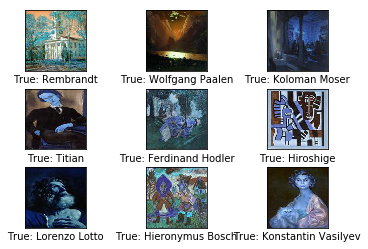

In [6]:
# Get some random images and their labels from the train set.

images, cls_true  = data.train.images, data.train.cls

# Plot the images and labels using our helper-function above.
plot_images(images=images, cls_true=cls_true)

### Helper-functions for creating new variables

In [7]:
def new_weights(shape):
    return tf.Variable(tf.truncated_normal(shape, stddev=0.05))

In [8]:
def new_biases(length):
    return tf.Variable(tf.constant(0.05, shape=[length]))

### Helper-function for creating a new Convolutional Layer

In [9]:
def new_conv_layer(input,              # The previous layer.
                   num_input_channels, # Num. channels in prev. layer.
                   filter_size,        # Width and height of each filter.
                   num_filters,        # Number of filters.
                   use_pooling=True):  # Use 2x2 max-pooling.

    # Shape of the filter-weights for the convolution.
    # This format is determined by the TensorFlow API.
    shape = [filter_size, filter_size, num_input_channels, num_filters]

    # Create new weights aka. filters with the given shape.
    weights = new_weights(shape=shape)

    # Create new biases, one for each filter.
    biases = new_biases(length=num_filters)

    # Create the TensorFlow operation for convolution.
    # Note the strides are set to 1 in all dimensions.
    # The first and last stride must always be 1,
    # because the first is for the image-number and
    # the last is for the input-channel.
    # But e.g. strides=[1, 2, 2, 1] would mean that the filter
    # is moved 2 pixels across the x- and y-axis of the image.
    # The padding is set to 'SAME' which means the input image
    # is padded with zeroes so the size of the output is the same.
    layer = tf.nn.conv2d(input=input,
                         filter=weights,
                         strides=[1, 1, 1, 1],
                         padding='SAME')

    # Add the biases to the results of the convolution.
    # A bias-value is added to each filter-channel.
    layer += biases

    # Use pooling to down-sample the image resolution?
    if use_pooling:
        # This is 2x2 max-pooling, which means that we
        # consider 2x2 windows and select the largest value
        # in each window. Then we move 2 pixels to the next window.
        layer = tf.nn.max_pool(value=layer,
                               ksize=[1, 2, 2, 1],
                               strides=[1, 2, 2, 1],
                               padding='SAME')

    # Rectified Linear Unit (ReLU).
    # It calculates max(x, 0) for each input pixel x.
    # This adds some non-linearity to the formula and allows us
    # to learn more complicated functions.
    layer = tf.nn.relu(layer)

    # Note that ReLU is normally executed before the pooling,
    # but since relu(max_pool(x)) == max_pool(relu(x)) we can
    # save 75% of the relu-operations by max-pooling first.

    # We return both the resulting layer and the filter-weights
    # because we will plot the weights later.
    return layer, weights

### Helper-function for flattening a layer


In [10]:
def flatten_layer(layer):
    # Get the shape of the input layer.
    layer_shape = layer.get_shape()

    # The shape of the input layer is assumed to be:
    # layer_shape == [num_images, img_height, img_width, num_channels]

    # The number of features is: img_height * img_width * num_channels
    # We can use a function from TensorFlow to calculate this.
    num_features = layer_shape[1:4].num_elements()
    
    # Reshape the layer to [num_images, num_features].
    # Note that we just set the size of the second dimension
    # to num_features and the size of the first dimension to -1
    # which means the size in that dimension is calculated
    # so the total size of the tensor is unchanged from the reshaping.
    layer_flat = tf.reshape(layer, [-1, num_features])

    # The shape of the flattened layer is now:
    # [num_images, img_height * img_width * num_channels]

    # Return both the flattened layer and the number of features.
    return layer_flat, num_features

### Helper-function for creating a new Fully-Connected Layer

In [11]:
def new_fc_layer(input,          # The previous layer.
                 num_inputs,     # Num. inputs from prev. layer.
                 num_outputs,    # Num. outputs.
                 use_relu=True): # Use Rectified Linear Unit (ReLU)?

    # Create new weights and biases.
    weights = new_weights(shape=[num_inputs, num_outputs])
    biases = new_biases(length=num_outputs)

    # Calculate the layer as the matrix multiplication of
    # the input and weights, and then add the bias-values.
    layer = tf.matmul(input, weights) + biases

    # Use ReLU?
    if use_relu:
        layer = tf.nn.relu(layer)

    return layer

In [12]:
x = tf.placeholder(tf.float32, shape=[None, img_size_flat], name='x')

In [13]:
x_image = tf.reshape(x, [-1, img_size, img_size, num_channels])

In [14]:
y_true = tf.placeholder(tf.float32, shape=[None, num_classes], name='y_true')

In [15]:
y_true_cls = tf.argmax(y_true, dimension=1)

### Convolutional Layer 1


In [16]:
layer_conv1, weights_conv1 = \
    new_conv_layer(input=x_image,
                   num_input_channels=num_channels,
                   filter_size=filter_size1,
                   num_filters=num_filters1,
                   use_pooling=True)

In [17]:
layer_conv1

<tf.Tensor 'Relu:0' shape=(?, 64, 64, 32) dtype=float32>

### Convolutional Layers 2 and 3

In [18]:
layer_conv2, weights_conv2 = \
    new_conv_layer(input=layer_conv1,
                   num_input_channels=num_filters1,
                   filter_size=filter_size2,
                   num_filters=num_filters2,
                   use_pooling=True)

In [19]:
layer_conv2

<tf.Tensor 'Relu_1:0' shape=(?, 32, 32, 32) dtype=float32>

In [20]:
layer_conv3, weights_conv3 = \
    new_conv_layer(input=layer_conv2,
                   num_input_channels=num_filters2,
                   filter_size=filter_size3,
                   num_filters=num_filters3,
                   use_pooling=True)

In [21]:
layer_conv3

<tf.Tensor 'Relu_2:0' shape=(?, 16, 16, 64) dtype=float32>

### Flatten Layer

In [22]:
layer_flat, num_features = flatten_layer(layer_conv3)

In [23]:
layer_flat

<tf.Tensor 'Reshape_1:0' shape=(?, 16384) dtype=float32>

In [24]:
num_features

16384

### Fully-Connected Layer 1

In [25]:
layer_fc1 = new_fc_layer(input=layer_flat,
                         num_inputs=num_features,
                         num_outputs=fc_size,
                         use_relu=True)

In [26]:
layer_fc1

<tf.Tensor 'Relu_3:0' shape=(?, 128) dtype=float32>

In [27]:
layer_fc2 = new_fc_layer(input=layer_fc1,
                         num_inputs=fc_size,
                         num_outputs=num_classes,
                         use_relu=False)

In [28]:
layer_fc2

<tf.Tensor 'add_4:0' shape=(?, 21) dtype=float32>

### Predicting Class

Using Softmax Classifier to classify the images.

In [29]:
y_pred = tf.nn.softmax(layer_fc2)

The class-number is the index of the largest element.

In [30]:
y_pred_cls = tf.argmax(y_pred, dimension=1)

### Cost-function to be optimized

In [31]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=layer_fc2,
                                                        labels=y_true)

In [32]:
cost = tf.reduce_mean(cross_entropy)

### Optimization Method

In [33]:
optimizer = tf.train.AdamOptimizer(learning_rate=1e-4).minimize(cost)

### Performance Measures

In [34]:
correct_prediction = tf.equal(y_pred_cls, y_true_cls)

In [35]:
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

## TensorFlow 

In [36]:
session = tf.Session()

### Initialize variables

In [37]:
session.run(tf.initialize_all_variables())

Instructions for updating:
Use `tf.global_variables_initializer` instead.


### Helper-function to perform optimization iterations

In [38]:
train_batch_size = batch_size

In [39]:
def print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss):
    # Calculate the accuracy on the training-set.
    acc = session.run(accuracy, feed_dict=feed_dict_train)
    val_acc = session.run(accuracy, feed_dict=feed_dict_validate)
    msg = "Epoch {0} --- Training Accuracy: {1:>6.1%}, Validation Accuracy: {2:>6.1%}, Validation Loss: {3:.3f}"
    print(msg.format(epoch + 1, acc, val_acc, val_loss))

In [40]:
# Counter for total number of iterations performed so far.
total_iterations = 0

def optimize(num_iterations):
    # Ensure we update the global variable rather than a local copy.
    global total_iterations

    # Start-time used for printing time-usage below.
    start_time = time.time()
    
    best_val_loss = float("inf")
    patience = 0

    for i in range(total_iterations,
                   total_iterations + num_iterations):

        # Get a batch of training examples.
        # x_batch now holds a batch of images and
        # y_true_batch are the true labels for those images.
        x_batch, y_true_batch, _, cls_batch = data.train.next_batch(train_batch_size)
        x_valid_batch, y_valid_batch, _, valid_cls_batch = data.valid.next_batch(train_batch_size)

        # Convert shape from [num examples, rows, columns, depth]
        # to [num examples, flattened image shape]

        x_batch = x_batch.reshape(train_batch_size, img_size_flat)
        x_valid_batch = x_valid_batch.reshape(train_batch_size, img_size_flat)

        # Put the batch into a dict with the proper names
        # for placeholder variables in the TensorFlow graph.
        feed_dict_train = {x: x_batch,
                           y_true: y_true_batch}
        
        feed_dict_validate = {x: x_valid_batch,
                              y_true: y_valid_batch}

        # Run the optimizer using this batch of training data.
        # TensorFlow assigns the variables in feed_dict_train
        # to the placeholder variables and then runs the optimizer.
        session.run(optimizer, feed_dict=feed_dict_train)
        

        # Print status at end of each epoch (defined as full pass through training dataset).
        if i % int(data.train.num_examples/batch_size) == 0: 
            val_loss = session.run(cost, feed_dict=feed_dict_validate)
            epoch = int(i / int(data.train.num_examples/batch_size))
            
            print_progress(epoch, feed_dict_train, feed_dict_validate, val_loss)
            
            if early_stopping:    
                if val_loss < best_val_loss:
                    best_val_loss = val_loss
                    patience = 0
                else:
                    patience += 1

                if patience == early_stopping:
                    break

    # Update the total number of iterations performed.
    total_iterations += num_iterations

    # Ending time.
    end_time = time.time()

    # Difference between start and end-times.
    time_dif = end_time - start_time

    # Print the time-usage.
    print("Time elapsed: " + str(timedelta(seconds=int(round(time_dif)))))

### Helper-function to plot example errors

In [41]:
def plot_example_errors(cls_pred, correct):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # correct is a boolean array whether the predicted class
    # is equal to the true class for each image in the test-set.

    # Negate the boolean array.
    incorrect = (correct == False)
    
    # Get the images from the test-set that have been
    # incorrectly classified.
    images = data.valid.images[incorrect]
    
    # Get the predicted classes for those images.
    cls_pred = cls_pred[incorrect]

    # Get the true classes for those images.
    cls_true = data.valid.cls[incorrect]
    
    # Plot the first 9 images.
    plot_images(images=images[0:9],
                cls_true=cls_true[0:9],
                cls_pred=cls_pred[0:9])

### Helper-function to plot confusion matrix

In [42]:
def plot_confusion_matrix(cls_pred):
    # cls_pred is an array of the predicted class-number for
    # all images in the test-set.

    # Get the true classifications for the test-set.
    cls_true = data.valid.cls
    
    # Get the confusion matrix using sklearn.
    cm = confusion_matrix(y_true=cls_true,
                          y_pred=cls_pred)

    # Print the confusion matrix as text.
    print(cm)

    # Plot the confusion matrix as an image.
    plt.matshow(cm)

    # Make various adjustments to the plot.
    plt.colorbar()
    tick_marks = np.arange(num_classes)
    plt.xticks(tick_marks, range(num_classes))
    plt.yticks(tick_marks, range(num_classes))
    plt.xlabel('Predicted')
    plt.ylabel('True')

    # Ensure the plot is shown correctly with multiple plots
    # in a single Notebook cell.
    plt.show()

## Performance after 1 optimization iteration

In [43]:
optimize(num_iterations=1)


Epoch 1 --- Training Accuracy:   0.0%, Validation Accuracy:   0.0%, Validation Loss: 2.997
Time elapsed: 0:00:00


## Performance after 100 optimization iterations

After 100 optimization iterations, the model should have significantly improved its classification accuracy.

In [47]:
optimize(num_iterations=99)  # We already performed 1 iteration above.

Epoch 24 --- Training Accuracy:  50.0%, Validation Accuracy:   0.0%, Validation Loss: 10.585
Epoch 25 --- Training Accuracy:  50.0%, Validation Accuracy:   0.0%, Validation Loss: 2.669
Epoch 26 --- Training Accuracy: 100.0%, Validation Accuracy:   0.0%, Validation Loss: 11.947
Epoch 27 --- Training Accuracy: 100.0%, Validation Accuracy:   0.0%, Validation Loss: 3.060
Epoch 28 --- Training Accuracy: 100.0%, Validation Accuracy:   0.0%, Validation Loss: 13.460
Epoch 29 --- Training Accuracy: 100.0%, Validation Accuracy:   0.0%, Validation Loss: 3.444
Epoch 30 --- Training Accuracy: 100.0%, Validation Accuracy:   0.0%, Validation Loss: 14.898
Epoch 31 --- Training Accuracy: 100.0%, Validation Accuracy:   0.0%, Validation Loss: 3.882
Time elapsed: 0:00:10


## Test on Sample Image

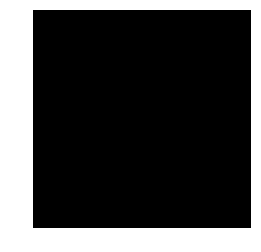

In [56]:
plt.axis('off')

test_img = cv2.imread('/home/gul/data/test/140.jpg')
test_img = cv2.resize(test_img, (img_size, img_size), cv2.INTER_LINEAR) / 255

preview_cat = plt.imshow(test_img.reshape(img_size, img_size, num_channels))

In [57]:
def sample_prediction(test_im):
    
    feed_dict_test = {
        x: test_im.reshape(1, img_size_flat),
        y_true: np.array([[20,19,18,17,16,15,14,13,12,11,10,9,8,7,6,5,4,3,2,1,0]])
    }

    test_pred = session.run(y_pred_cls, feed_dict=feed_dict_test)
    return classes[test_pred[0]]


print("Predicted class of first image: {}".format(sample_prediction(test_img)))


Predicted class of first image: Wolfgang Paalen


In [48]:
session.close()